In [1]:
#%% relevant paths
data='/home/mfeldmann/data/'
figs='/storage/homefs/mf23m219/figs/dyn_comp/'
scr_data='/storage/homefs/mf23m219/clim/composite/'
code='/home/mfeldmann/code/'
import sys, os
sys.path.append(code)
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
#from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.morphology as skimo
from scipy.ndimage import convolve
from skimage.measure import label, regionprops
from scipy.ndimage import binary_erosion
import copy
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.colors as colors

In [26]:

file=np.load('/storage/homefs/mf23m219/clusters/cluster.npz')
arrays=file.files
labels=file['arr_0']
rregs=file['arr_1']
ids=file['arr_2']
print(rregs,ids)

regs = xr.open_dataset('/storage/homefs/mf23m219/clim/regions.nc')['__xarray_dataarray_variable__']
mask = (regs.values!=9)
print(np.unique(mask))
mask = mask * 1.0
mask[mask==0]=np.nan
regs = regs*mask

regs = regs.fillna(-5)

mask2 = regs>0

['HELLEN' 'BENELUX' 'ADRIA' 'ALTA-ITALIA' 'EAST' 'SLAV' 'W-MED' 'MAHGREB'
 'CENTRAL'] [ 2  3  4  5  6  7  8  9 10]
[False  True]


In [27]:
scr_data='/storage/homefs/mf23m219/clim/'

# cape = xr.open_dataset(scr_data+'ym_slope_xr_EUR_40yr_cape_trend.nc').polyfit_coefficients * 10 * mask2
# s_cape = xr.open_dataset(scr_data+'ym_std_xr_EUR_40yr_cape_trend.nc') * mask2
# temp = xr.open_dataset(scr_data+'ym_slope_xr_EUR_40yr_t2m_trend.nc').polyfit_coefficients * 10 * mask2
# s_temp = xr.open_dataset(scr_data+'ym_std_xr_EUR_40yr_t2m_trend.nc') * mask2
# conv = xr.open_dataset(scr_data+'ym_slope_xr_EUR_40yr_conv_trend.nc').polyfit_coefficients * 10 * 100 * mask2
# s_conv = xr.open_dataset(scr_data+'ym_std_xr_EUR_40yr_conv_trend.nc') * mask2 * 100
# rh = xr.open_dataset(scr_data+'ym_slope_xr_EUR_40yr_rh_trend.nc').polyfit_coefficients * 10 * 100 * mask2
# s_rh = xr.open_dataset(scr_data+'ym_std_xr_EUR_40yr_rh_trend.nc') * mask2 * 100

cape = xr.open_dataset(scr_data+'ym_slope_hr_EUR_40yr_cape_trend.nc').cape * 10 * mask2
s_cape = xr.open_dataset(scr_data+'ym_pval_hr_EUR_40yr_cape_trend.nc').cape * mask2
temp = xr.open_dataset(scr_data+'ym_slope_hr_EUR_40yr_t2m_trend.nc').t2m * 10 * mask2
s_temp = xr.open_dataset(scr_data+'ym_pval_hr_EUR_40yr_t2m_trend.nc').t2m * mask2
conv = xr.open_dataset(scr_data+'ym_slope_hr_EUR_40yr_conv_trend.nc').conv_EU * 10 * 100 * mask2
s_conv = xr.open_dataset(scr_data+'ym_pval_hr_EUR_40yr_conv_trend.nc').conv_EU * mask2
rh = xr.open_dataset(scr_data+'ym_slope_hr_EUR_40yr_rh_trend.nc').rh * 10 * 100 * mask2
s_rh = xr.open_dataset(scr_data+'ym_pval_hr_EUR_40yr_rh_trend.nc').rh * mask2
q900 = xr.open_dataset(scr_data+'ym_slope_hr_EUR_40yr_q900_trend.nc').q900 * 10 * 1000 * mask2
s_q900 = xr.open_dataset(scr_data+'ym_pval_hr_EUR_40yr_q900_trend.nc').q900 * mask2



In [45]:
for inx,n in enumerate(np.unique(regs)[1:]):
    print(rregs[inx])
    mmask = (regs==n)*1.0
    mmask = mmask.where(mmask!=0,np.nan)
    print('CAPE',np.nanmean(cape*mmask))
    print('t2m',np.nanmean(temp*mmask))
    print('CIX',np.nanmean(conv*mmask))
    print('rh',np.nanmean(rh*mmask))
    print('q900',np.nanmean(q900*mmask))

HELLEN
CAPE 31.46215308315865
t2m 0.4333936040624554
CIX 0.1065282343168247
rh -0.8936983343568053
q900 0.09295689939667814
BENELUX
CAPE 15.112089680323203
t2m 0.4460001278426106
CIX 0.4103907884092158
rh -1.2434599754052311
q900 0.05099586926575538
ADRIA
CAPE 71.34276179421303
t2m 0.495984090923285
CIX 0.6645422414704073
rh -1.0936616963846193
q900 0.12988327087288917
ALTA-ITALIA
CAPE 83.06081878317558
t2m 0.5399902377085122
CIX 1.6856433169147411
rh -0.9737108042677574
q900 0.15316433992601713
EAST
CAPE 4.033844126631806
t2m 0.5732839731853105
CIX -0.23537801855121457
rh -1.8020869028271738
q900 0.054530113772550494
SLAV
CAPE 39.508387926108576
t2m 0.49886842575685497
CIX 0.9206226049878207
rh -0.7891565566092448
q900 0.09856282488190896
W-MED
CAPE 21.34492089616125
t2m 0.4579015798363032
CIX 0.46390535355714035
rh -1.618692670667258
q900 0.051040063393467686
MAHGREB
CAPE 23.86767441787278
t2m 0.5034473063932838
CIX 0.7829214886564023
rh -0.990828818337101
q900 0.09159919907808028


/tmp/ipykernel_1112487/1153806193.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


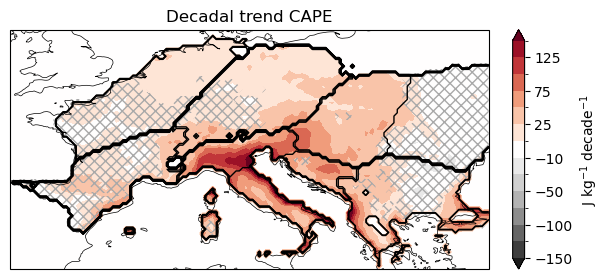

In [19]:
latslice=slice(37,55)
lonslice=slice(-6,30)

cmap = plt.get_cmap('RdGy_r')
#cmap.set_under('w')
cmap.set_bad('w')

#hatch = (s_cape > abs(4.2*cape)).__xarray_dataarray_variable__
hatch = (s_cape > 0.05 )
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
cape.sel(lat=latslice,lon=lonslice).plot.contourf(cmap=cmap,extend='both',levels=[-150,-125,-100,-75,-50,-25,-10,10,25,50,75,100,125,150],
                                                  ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"J kg$^{-1}$ decade$^{-1}$"},)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
hatch_plot=hatch.sel(lat=latslice,lon=lonslice).plot.contourf(ax=axes,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
for collection in hatch_plot.collections:
    collection.set_edgecolor('darkgrey')
    collection.set_linewidth(0) 
axes.add_feature(coastline, linewidth=0.5)
plt.title('Decadal trend CAPE')
fig.savefig(figs+'trend_cape.png',  dpi=300, format=None,)

/tmp/ipykernel_1112487/1000422210.py:19: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


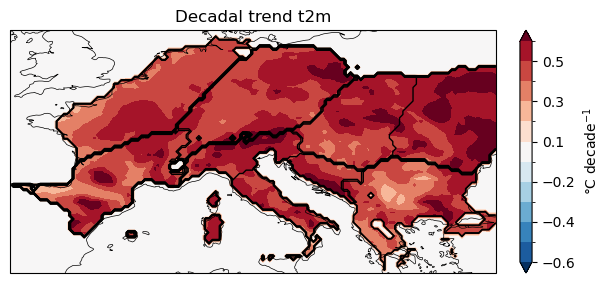

In [25]:
# hatch = (s_temp > 4.2*temp).__xarray_dataarray_variable__
hatch = (s_temp > 0.05 )
latslice=slice(37,55)
lonslice=slice(-6,30)
cmap = plt.get_cmap('RdBu_r')
# cmap.set_under('w')
cmap.set_bad('w')

coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
temp.sel(lat=latslice,lon=lonslice).plot.contourf(vmin=-0.6,vmax=0.6,cmap=cmap,extend='both',levels=[-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6],
                                                  ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"°C decade$^{-1}$"},)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
hatch_plot=hatch.sel(lat=latslice,lon=lonslice).plot.contourf(ax=axes,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
for collection in hatch_plot.collections:
    collection.set_edgecolor('darkgrey')
    collection.set_linewidth(0) 
axes.add_feature(coastline, linewidth=0.5)
plt.title('Decadal trend t2m')
fig.savefig(figs+'trend_t2m.png',  dpi=300, format=None,)

/tmp/ipykernel_1112487/3440562352.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


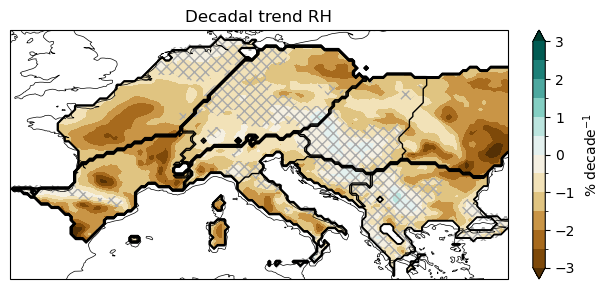

In [26]:
# hatch = (s_rh > abs(4.2*rh)).__xarray_dataarray_variable__
hatch = (s_rh > 0.05 )
latslice=slice(37,55)
lonslice=slice(-6,30)

cmap = plt.get_cmap('BrBG')
# cmap.set_under('w')
cmap.set_bad('w')
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
rh = rh.where(rh != 0)
rh.sel(lat=latslice,lon=lonslice).plot.contourf(vmin=-3,vmax=3,cmap=cmap,extend='both',levels=[-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]
                                                ,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"% decade$^{-1}$"},)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
hatch_plot=hatch.sel(lat=latslice,lon=lonslice).plot.contourf(ax=axes,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
for collection in hatch_plot.collections:
    collection.set_edgecolor('darkgrey')
    collection.set_linewidth(0) 
axes.add_feature(coastline, linewidth=0.5)
plt.title('Decadal trend RH')
fig.savefig(figs+'trend_rh.png',  dpi=300, format=None,)

/tmp/ipykernel_2346545/4125851904.py:20: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


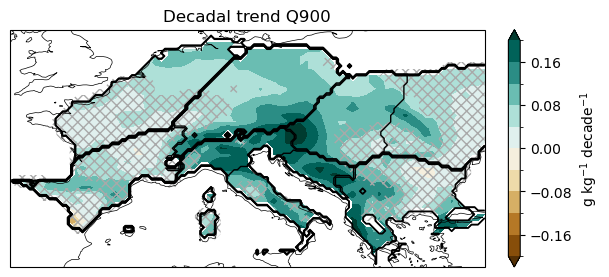

In [8]:
# hatch = (s_rh > abs(4.2*rh)).__xarray_dataarray_variable__
hatch = (s_q900 > 0.05 )
latslice=slice(37,55)
lonslice=slice(-6,30)

cmap = plt.get_cmap('BrBG')
# cmap.set_under('w')
cmap.set_bad('w')
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
q900 = q900.where(rh != 0)
q900.sel(lat=latslice,lon=lonslice).plot.contourf(vmin=-3,vmax=3,cmap=cmap,extend='both',levels=np.arange(-0.2,0.21,0.04)
                                                ,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"g kg$^{-1}$ decade$^{-1}$"},)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
hatch_plot=hatch.sel(lat=latslice,lon=lonslice).plot.contourf(ax=axes,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
for collection in hatch_plot.collections:
    collection.set_edgecolor('darkgrey')
    collection.set_linewidth(0) 
axes.add_feature(coastline, linewidth=0.5)
plt.title('Decadal trend Q900')
fig.savefig(figs+'trend_q900.png',  dpi=300, format=None,)

/tmp/ipykernel_3213216/3644305306.py:19: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


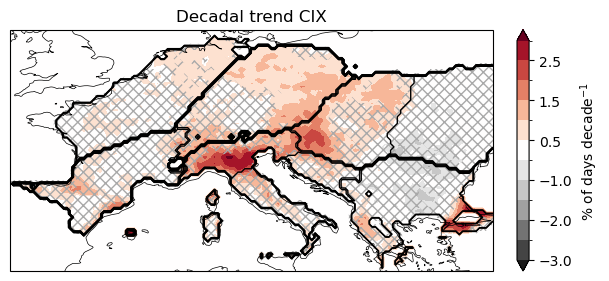

In [4]:
# hatch = (s_conv > abs(4.2*conv)).__xarray_dataarray_variable__
hatch = (s_conv > 0.05 )
latslice=slice(37,55)
lonslice=slice(-6,30)
cmap = plt.get_cmap('RdGy_r')
cmap.set_under('w')
cmap.set_bad('w')

coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
conv.sel(lat=latslice,lon=lonslice).plot.contourf(vmin=-4,vmax=4,cmap='RdGy_r',extend='both',levels=[-3,-2.5,-2,-1.5,-1,-0.5,0.5,1,1.5,2,2.5,3]
                                                  ,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"% of days decade$^{-1}$"},)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
hatch_plot=hatch.sel(lat=latslice,lon=lonslice).plot.contourf(ax=axes,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
for collection in hatch_plot.collections:
    collection.set_edgecolor('darkgrey')
    collection.set_linewidth(0) 
axes.add_feature(coastline, linewidth=0.5)
plt.title('Decadal trend CIX')
fig.savefig(figs+'trend_conv.png',  dpi=300, format=None,)

In [46]:
scr_data='/storage/homefs/mf23m219/clim/'

f1 = scr_data + 'EUR_40yr_sfc.nc'
f2 = scr_data + 'EUR_40yr_pl.nc'
f3 = scr_data + 'EUR_40yr_hrconv.nc'
f4 = '/storage/homefs/mf23m219/land_sea_mask_era5.nc'

lsm = xr.open_dataset(f4).islnd
lsm['lon'] = xr.where(lsm['lon'] > 180, lsm['lon'] - 360, lsm['lon'])
cape = xr.open_dataset(f1).cape.mean(dim='time',skipna=True) * mask2
temp = xr.open_dataset(f1).t2m.mean(dim='time',skipna=True) * mask2
#shear = xr.open_dataset(f2).shear
conv = xr.open_dataset(f3).conv_EU.mean(dim='time',skipna=True) * mask2
rh = xr.open_dataset(f1).rh.mean(dim='time',skipna=True) * mask2 * 100
q900 = xr.open_dataset(f2).q900.mean(dim='time',skipna=True) * mask2 * 1000

In [47]:
for inx,n in enumerate(np.unique(regs)[1:]):
    print(rregs[inx])
    mmask = (regs==n)*1.0
    mmask = mmask.where(mmask!=0,np.nan)
    print('CAPE',np.nanmean(cape*mmask))
    print('t2m',np.nanmean(temp*mmask))
    print('CIX',np.nanmean(conv*mmask))
    print('rh',np.nanmean(rh*mmask))
    print('q900',np.nanmean(q900*mmask))

HELLEN
CAPE 392.3136535279779
t2m 292.8980592117208
CIX 0.11611798739076222
rh 66.09410157020032
q900 7.778957163321006
BENELUX
CAPE 207.35679662715006
t2m 289.49360354934606
CIX 0.05571805149315712
rh 73.48651367524711
q900 6.725470105806987
ADRIA
CAPE 540.8982095891779
t2m 292.98658440329814
CIX 0.154585526952148
rh 68.40659447583285
q900 7.666329188006265
ALTA-ITALIA
CAPE 494.70081026944246
t2m 289.48663518732246
CIX 0.17890754328510824
rh 72.11777367331764
q900 7.897826557728782
EAST
CAPE 345.8693204565523
t2m 290.4391896916532
CIX 0.07942742077475896
rh 69.93328592390546
q900 7.475040057196689
SLAV
CAPE 353.898252751277
t2m 290.9724905630258
CIX 0.09380265880949876
rh 69.09757010239821
q900 7.497150871488783
W-MED
CAPE 346.57491486331065
t2m 291.08117354059794
CIX 0.13073246016441506
rh 68.34731508737588
q900 7.6194362037153125
MAHGREB
CAPE 254.3906225971616
t2m 288.71286671905364
CIX 0.07516134053475217
rh 71.44973005717593
q900 7.0443910040506506


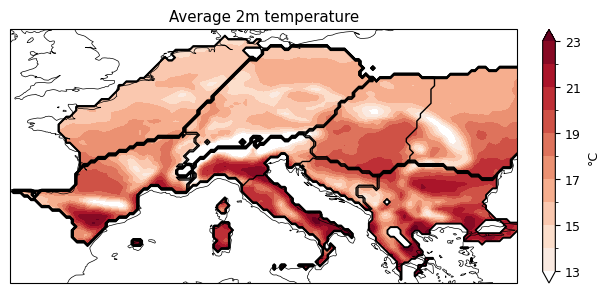

In [126]:

import matplotlib.colors as colors
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))
new_cmap.set_under('w')
new_cmap.set_bad('w')

latslice=slice(37,55)
lonslice=slice(-6,30)
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
(temp-273.5).sel(lat=latslice,lon=lonslice).plot.contourf(vmin=13,vmax=23,cmap=new_cmap,levels=11,
                        ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"°C"},extend='both')
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
axes.add_feature(coastline, linewidth=0.5)
plt.title('Average 2m temperature')
fig.savefig(figs+'t2m.png',  dpi=300, format=None,)

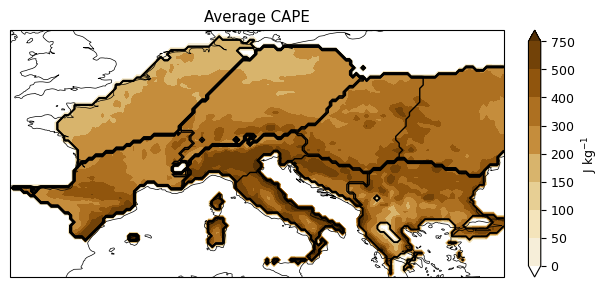

In [130]:
cmap = plt.get_cmap('BrBG_r')
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))
new_cmap.set_under('w')
new_cmap.set_bad('w')
latslice=slice(37,55)
lonslice=slice(-6,30)
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
(cape).sel(lat=latslice,lon=lonslice).plot.contourf(levels=[0,50,100,150,200,300,400,500,750],vmin=1,
            cmap=new_cmap,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"J kg$^{-1}$"},extend='both')
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
axes.add_feature(coastline, linewidth=0.5)
plt.title('Average CAPE')
fig.savefig(figs+'cape.png',  dpi=300, format=None,)

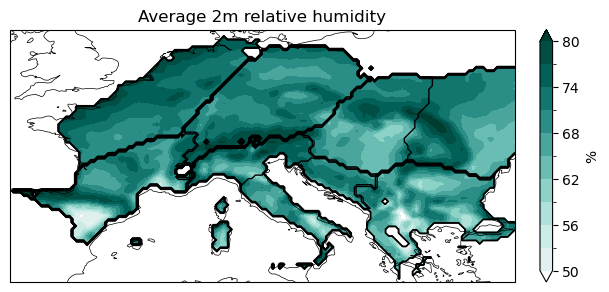

In [10]:
cmap = plt.get_cmap('BrBG')
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))
new_cmap.set_under('w')
new_cmap.set_bad('w')
latslice=slice(37,55)
lonslice=slice(-6,30)
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
(rh).sel(lat=latslice,lon=lonslice).plot.contourf(vmin=50,vmax=80,levels=11,
        cmap=new_cmap,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"%"},extend='both')
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
axes.add_feature(coastline, linewidth=0.5)
plt.title('Average 2m relative humidity')
fig.savefig(figs+'r2m.png',  dpi=300, format=None,)

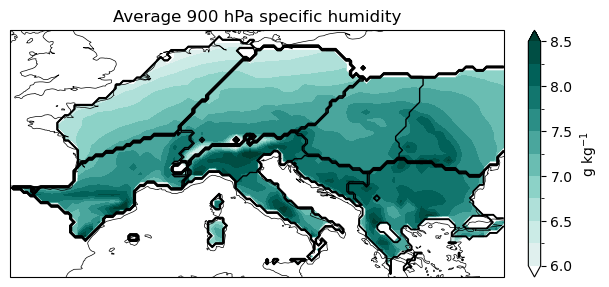

In [15]:
cmap = plt.get_cmap('BrBG')
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))
new_cmap.set_under('w')
new_cmap.set_bad('w')
latslice=slice(37,55)
lonslice=slice(-6,30)
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
(q900).sel(lat=latslice,lon=lonslice).plot.contourf(vmin=6,vmax=8.5,levels=11,
        cmap=new_cmap,ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"g kg$^{-1}$"},extend='both')
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
axes.add_feature(coastline, linewidth=0.5)
plt.title('Average 900 hPa specific humidity')
fig.savefig(figs+'q900.png',  dpi=300, format=None,)

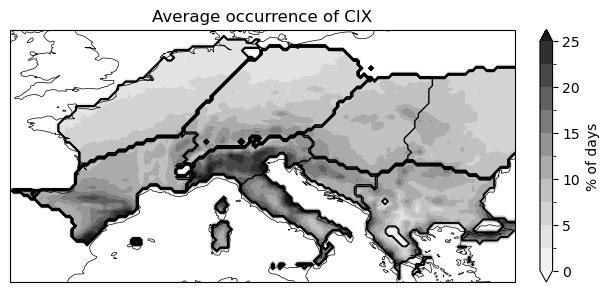

In [6]:
cmap = plt.get_cmap('RdGy')
#cmap.set_under('dimgray')
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))
new_cmap.set_under('w')
new_cmap.set_bad('w')
latslice=slice(37,55)
lonslice=slice(-6,30)
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
fig,axes = plt.subplots(1,1,figsize=(6, 3), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
(conv*100).sel(lat=latslice,lon=lonslice).plot.contourf(vmin=0,vmax=25,cmap=new_cmap,levels=11,
            ax=axes, transform=ccrs.PlateCarree(),cbar_kwargs={"label": r"% of days"},extend='both')
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes,colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
axes.add_feature(coastline, linewidth=0.5)
plt.title('Average occurrence of CIX')
fig.savefig(figs+'conv.png',  dpi=300, format=None,)

In [16]:
scr_data='/storage/homefs/mf23m219/clim/'
reg_arr = xr.open_dataset(scr_data+'/regions.nc')

conv_EU = xr.open_dataset(scr_data+'EUR_40yr_hrconv.nc').conv_EU
cp_EU = xr.open_dataset(scr_data+'EUR_40yr_sfc.nc').cp
reg_arr = xr.open_dataset(scr_data+'regions.nc')

file=np.load('/storage/homefs/mf23m219/clusters/cluster.npz')
regs=file['arr_1']
ids=file['arr_2']

n_events=[]
n_single=[]
n_multi=[]
n_days=[]
n_size=[]
for reg in [1,8,5,4,6,3,2,0]:
    region = ids[reg]
    regtag = regs[reg]

    reg_arr_bin = reg_arr==region
    reg_size = reg_arr_bin.sum(dim=['lat','lon'],skipna=True)
    conv_reg = conv_EU * reg_arr_bin
    cp_reg = (conv_reg * cp_EU).max(dim=['lat','lon'],skipna=True)
    conv_size = conv_reg.sum(dim=['lat','lon'],skipna=True)
    conv_events = conv_size.isel(time=np.where(((conv_size>(0.25*reg_size)) & (cp_reg>0)).__xarray_dataarray_variable__.values)[0]).sortby('time',ascending=True).time

    dates_diff = conv_events.diff(dim='time').dt.days.fillna(0)
    first_days = conv_events.isel(time=np.where(dates_diff>1)[0]-1).time
    second_days = conv_events.isel(time=(np.where(dates_diff>1)[0])).time
    delta_days = (second_days.time.values - first_days.time.values)/np.timedelta64(1, "D")

    single_days = first_days[delta_days>3]
    multi_days = first_days[delta_days<=1]

    n_days.append(len(conv_events))
    n_events.append(len(first_days))
    n_single.append(len(single_days))
    n_multi.append(len(multi_days))
    n_size.append(reg_size.__xarray_dataarray_variable__.values)

n_size = np.array(n_size)

[False  True]


/tmp/ipykernel_2346545/2065352244.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


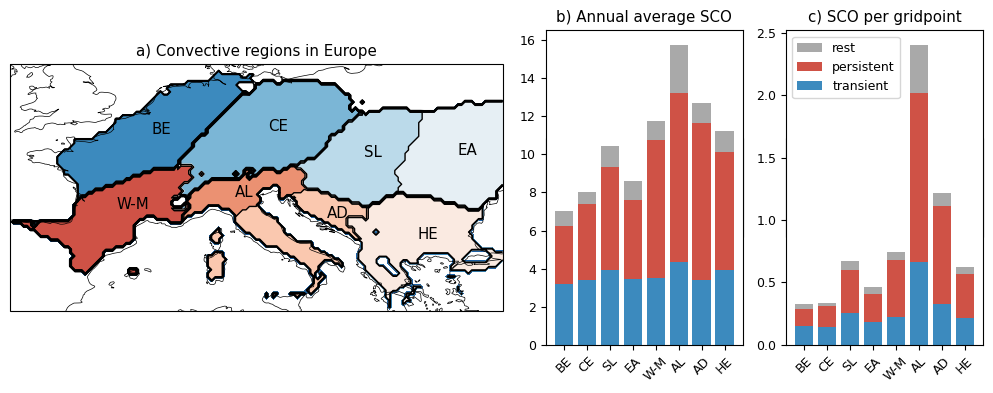

In [17]:
regs = xr.open_dataset('/storage/homefs/mf23m219/clim/regions.nc')['__xarray_dataarray_variable__']
mask = (regs.values!=9)
print(np.unique(mask))
mask = mask * 1.0
mask[mask==0]=np.nan
regs = regs*mask

regs = regs.fillna(-5)

regs2 = copy.deepcopy(regs)

regs2 = regs2.where(regs != 8, 8)
regs2 = regs2.where(regs != 5, 7)
regs2 = regs2.where(regs != 4, 6)
regs2 = regs2.where(regs != 2, 5)
regs2 = regs2.where(regs != 3, 1)
regs2 = regs2.where(regs != 10, 2)
regs2 = regs2.where(regs != 7, 3)
regs2 = regs2.where(regs != 6, 4)

labels = ['BE','CE','SL','EA','W-M','AL','AD','HE']
index = [1,2,3,4,8,7,6,5]
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.colors as mcolors

plt.rcParams.update({
    "font.size": 9,  # Adjust this value as needed
})

fig, axes = plt.subplots(1,3,figsize=(10,4), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed',gridspec_kw={'width_ratios': [2.5, 1, 1]})#EuroPP
latslice=slice(37,55);lonslice=slice(-6,30)
cmap = plt.get_cmap('seismic')
cmap = plt.get_cmap('RdBu_r')
cmap.set_under(color='w')
cmap.set_bad(color='w')

regs2.sel(lat=latslice,lon=lonslice).plot.contourf(ax = axes[0],cmap=cmap, add_colorbar=False,vmin=0,vmax=12,levels=np.arange(-0.5,11.5,1), transform=ccrs.PlateCarree())
# regs.sel(lat=latslice,lon=lonslice).plot.contour(colors='k', linewidths=4, levels = [-100,9.5,100], add_colorbar=False,)
regs.sel(lat=latslice,lon=lonslice).plot.contour(ax = axes[0],colors='k', linewidths=1, levels = np.arange(0.5,11.5,1), add_colorbar=False, transform=ccrs.PlateCarree())
coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'  # Set coastline color here
)
axes[0].add_feature(coastline, linewidth=0.5)
axes[0].set_title('a) Convective regions in Europe')
for n2 in range(len(labels)):
    lab = regs2==index[n2]
    lons = (lab * regs2.lon).values
    lons = np.nanmean(lons[lons!=0])
    lats = (lab * regs2.lat).values
    lats = np.nanmean(lats[lats!=0])
    if n2==4: lats+=0.5
    if n2==5: lats-=0.5;lons-=0.75
    if n2==6: lats+=1.2;lons+=2.5

    axes[0].text(lons,lats,labels[n2],size='large')


# axes[1] = fig.add_subplot(1,3, 2)
# axes[1].bar(range(len(n_events)),(np.array(n_events))/(n_size),color='darkgrey',label='rest')
# axes[1].bar(range(len(n_single)),(np.array(n_single)+np.array(n_multi))/(n_size),color='#cf5246',label='persistent')#eb9172
# axes[1].bar(range(len(n_single)),np.array(n_single)/(n_size),color='#3c8abe',label='transient')
# axes[1].set_xticks(range(len(n_single)),labels,rotation=45)
# axes[1].legend(loc='upper left')
# axes[1].set_title('SCO per gridpoint')

axes[1] = fig.add_subplot(1,3, 2)
axes[1].bar(range(len(n_events)),(np.array(n_events))/(42),color='darkgrey',label='rest')
axes[1].bar(range(len(n_single)),(np.array(n_single)+np.array(n_multi))/(42),color='#cf5246',label='persistent')
axes[1].bar(range(len(n_single)),np.array(n_single)/(42),color='#3c8abe',label='transient')#7bb6d6
axes[1].set_xticks(range(len(n_single)),labels,rotation=45)
axes[1].set_title('b) Annual average SCO')

axes[2] = fig.add_subplot(1,3, 3)
axes[2].bar(range(len(n_events)),(np.array(n_events))/(n_size),color='darkgrey',label='rest')
axes[2].bar(range(len(n_single)),(np.array(n_single)+np.array(n_multi))/(n_size),color='#cf5246',label='persistent')#eb9172
axes[2].bar(range(len(n_single)),np.array(n_single)/(n_size),color='#3c8abe',label='transient')
axes[2].set_xticks(range(len(n_single)),labels,rotation=45)
axes[2].legend(loc='upper left')
axes[2].set_title('c) SCO per gridpoint')
plt.tight_layout()
plt.savefig(figs+'intro.png',  dpi=300, format=None,)

colors=['firebrick','darkgoldenrod','chocolate','tomato',
 'dodgerblue','royalblue','mediumslateblue','mediumorchid']

In [78]:
lons

np.float64(0.0475170768730348)

[False  True]


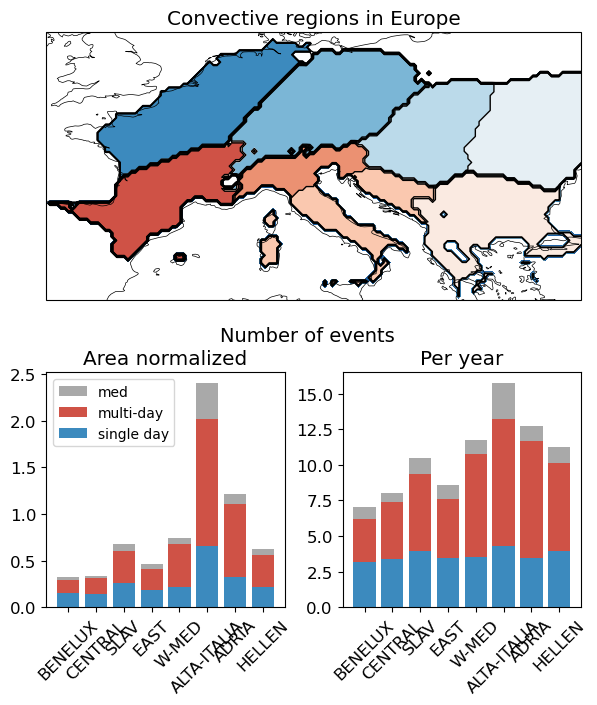

In [18]:
regs = xr.open_dataset('/storage/homefs/mf23m219/clim/regions.nc')['__xarray_dataarray_variable__']
mask = (regs.values!=9)
print(np.unique(mask))
mask = mask * 1.0
mask[mask==0]=np.nan
regs = regs*mask

regs = regs.fillna(-5)

regs2 = copy.deepcopy(regs)

regs2 = regs2.where(regs != 8, 8)
regs2 = regs2.where(regs != 5, 7)
regs2 = regs2.where(regs != 4, 6)
regs2 = regs2.where(regs != 2, 5)
regs2 = regs2.where(regs != 3, 1)
regs2 = regs2.where(regs != 10, 2)
regs2 = regs2.where(regs != 7, 3)
regs2 = regs2.where(regs != 6, 4)

mpl.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(6, 8))  # Taller figure for layout
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  # Top row taller

# Top full-width map plot
ax_map = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())

# Bottom two bar plots
ax_bar1 = fig.add_subplot(gs[1, 0])
ax_bar2 = fig.add_subplot(gs[1, 1])

# ========== Plotting the map ==========
latslice = slice(37, 55)
lonslice = slice(-6, 30)

cmap = plt.get_cmap('RdBu_r')
cmap.set_under(color='w')
cmap.set_bad(color='w')

regs2.sel(lat=latslice, lon=lonslice).plot.contourf(
    ax=ax_map, cmap=cmap, add_colorbar=False, vmin=0, vmax=12,
    levels=np.arange(-0.5, 11.5, 1), transform=ccrs.PlateCarree()
)
regs.sel(lat=latslice, lon=lonslice).plot.contour(
    ax=ax_map, colors='k', linewidths=1, levels=np.arange(0.5, 11.5, 1),
    add_colorbar=False, transform=ccrs.PlateCarree()
)

coastline = cfeature.NaturalEarthFeature(
    category='physical', name='coastline', scale='50m',
    edgecolor='black', facecolor='none'
)
ax_map.add_feature(coastline, linewidth=0.5)
ax_map.set_title('Convective regions in Europe')

# ========== Bar plots ==========
labels = ['BENELUX', 'CENTRAL', 'SLAV', 'EAST', 'W-MED', 'ALTA-ITALIA', 'ADRIA', 'HELLEN']
fig.text(0.5, 0.46, 'Number of events', ha='center', va='bottom', fontsize=14)
# Bar plot 1: Normalized
ax_bar1.bar(range(len(n_events)), np.array(n_events) / n_size, color='darkgrey', label='med')
ax_bar1.bar(range(len(n_single)), (np.array(n_single) + np.array(n_multi)) / n_size, color='#cf5246', label='multi-day')
ax_bar1.bar(range(len(n_single)), np.array(n_single) / n_size, color='#3c8abe', label='single day')
ax_bar1.set_xticks(range(len(n_single)))
ax_bar1.set_xticklabels(labels, rotation=45)
ax_bar1.legend(loc='upper left', fontsize=10)
ax_bar1.set_title('Area normalized')

# Bar plot 2: Absolute
ax_bar2.bar(range(len(n_events)), np.array(n_events) / 42, color='darkgrey', label='med')
ax_bar2.bar(range(len(n_single)), (np.array(n_single) + np.array(n_multi)) / 42, color='#cf5246', label='multi-day')
ax_bar2.bar(range(len(n_single)), np.array(n_single) / 42, color='#3c8abe', label='single day')
ax_bar2.set_xticks(range(len(n_single)))
ax_bar2.set_xticklabels(labels, rotation=45)
ax_bar2.set_title('Per year')

# Final layout and save
plt.tight_layout()
plt.savefig(figs + 'intro.png', dpi=300)

In [19]:
file=np.load('/storage/homefs/mf23m219/clusters/cluster.npz')
arrays=file.files
labels=file['arr_0']
regs=file['arr_1']
ids=file['arr_2']


labels = xr.open_dataset('/storage/homefs/mf23m219/clim/regions.nc')['__xarray_dataarray_variable__']
mask = (labels.values!=9)
print(np.unique(mask))
mask = mask * 1.0
mask[mask==0]=np.nan
labels = labels*mask

labels = labels.fillna(-5)
labels = labels.pad(lon=(0,5),constant_values=-5)
labels = labels.assign_coords(lon=np.arange(-70,31.3,0.25))

print(regs,ids)

plt.rcParams.update({
    "font.size": 14,  # Adjust this value as needed
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

[False  True]
['HELLEN' 'BENELUX' 'ADRIA' 'ALTA-ITALIA' 'EAST' 'SLAV' 'W-MED' 'MAHGREB'
 'CENTRAL'] [ 2  3  4  5  6  7  8  9 10]


In [27]:
scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
#files = glob(scr_data+'static_composite_frs_*_DI_*test*')
vars = ['q700','q800','rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_inf','WCB_mid','cape','LTG_ANOM']
clabels = [r"$\Delta$ 700 hPa Specific Humidity [g kg$^{-1}$]",r"$\Delta$ 800 hPa Specific Humidity [g kg$^{-1}$]",r"$\Delta$ 900 hPa Relative Humidity [%]",r"$\Delta$ 2m Relative Humidity [%]",r"$\Delta$ Sea Surface Temperature [°C]",
           r"$\Delta$ 900 hPa Specific Humidity [g kg$^{-1}$]",r"$\Delta$ 500 hPa Geopotential Height [m]",
           r"$\Delta$ 2m Temperature [°C]",r"$\Delta$ Surface Soil Moisture [l m$^{-3}$]",r"Heatwave Occurrence [0-1]",
           r"$\Delta$ Convective Precipitation [mm]",r"Convective Proxy [0-1]",r"$\Delta$ Dry Intrusions [0-1]",
           r"$\Delta$ Warm Conveyor Belt Inflow [0-1]",r"$\Delta$ Warm Conveyor Belt Ascent [0-1]",
           r"$\Delta$ CAPE [J kg$^{-1}$]",r"$\Delta$ LTG [# 0.25°$^{-1}$]"]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['BrBG','BrBG','BrBG','BrBG','RdBu_r','BrBG','RdBu_r','RdBu_r','BrBG','Reds','Blues','bone_r','RdBu_r','RdBu_r','RdBu_r','Reds','RdGy_r']
scope = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
ids = [3,10,7,6,8,5,4,2]
days = ['frs']#,'sgl','mlt','all']
bounds = [np.arange(-1,1.1,0.2),
          np.arange(-1,1.1,0.2),
          np.arange(-12,12.1,2),
          np.arange(-8,8.1,2),
          np.arange(-0.8,0.81,0.2),
          np.arange(-1.6,1.61,0.4),
          np.arange(-55,55.1,10),
          np.arange(-3,3.1,0.5),
          np.arange(-30,30.1,5),
          np.arange(0,31,5),
          np.arange(0,3.1,0.5),
          np.arange(0,0.76,0.1),
          np.arange(-15,15.1,3),
          np.arange(-15,15.1,3),
          np.arange(-15,15.1,3),
          np.arange(0,1001,50),
          np.arange(-0.2,0.21,0.02),
]
for day in days:
    for n1 in range(len(vars))[-1:]:
        var = vars[n1]
        print(var)
        data=[]
        pval=[]
        n=0
        for reg in regs:
            print(reg)
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]

            file = glob(scr_data+'static_pval_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            pval.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            pval[n] = pval[n][list(pval[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        pval = xr.concat(pval,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        if var=='rh': data = data*100
        if var=='SWVL1': data = data*1000
        if var=='DI': data = data*100
        if var=='WCB_all': data = data*100
        if var=='WCB_inf': data = data*100
        if var=='WCB_mid': data = data*100
        if var=='hwp': data = data*100
        if var=='q900': data = data*1000
        if var=='q800': data = data*1000
        if var=='q700': data = data*1000
        if var=='z500': data = data/9.81
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contourf(x='lon',y='lat',col='region',col_wrap=4,
                                                                                             cmap=cmaps[n1],levels=bounds[n1],extend='both',
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='black',linestyles='solid',ax=ax)

            psel = pval.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            pcor = psel.values.flatten()
            nan_mask = np.isnan(pcor)
            pp = pcor[~nan_mask]
            psel_fdr = fdrcorrection(pp)[1]
            pcor[~nan_mask] = psel_fdr
            psel_fdr = pcor.reshape(psel.shape)
            psel_fdr = xr.DataArray(
                psel_fdr,
                coords={ "lat": psel.lat, "lon": psel.lon},  # Preserve time/lon coordinates
                dims=["lat", "lon"],
            )

            hatch_plot = psel_fdr.plot.contourf(ax=ax,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
            for collection in hatch_plot.collections:
                collection.set_edgecolor('darkgrey')
                collection.set_linewidth(0) 
            ax.coastlines(color='dimgrey')
            ax.set_title('')
            ax.set_ylabel('')
            ax.set_xlabel('')
            # ax.set_xticks(np.arange(-10,40,10))
            # ax.set_yticks(np.arange(35,60,10))
            # if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            # if n2==0 or n2==4: ax.set_ylabel('Latitude',fontsize=10)
            #ax.set_title(regs[n2])
            if n2==4: ax.text(28,55,'W-M')
            else: ax.text(32,55,regs[n2][:2])
            n2+=1
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axes, orientation='vertical', shrink=0.7,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1],fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_t0_regs.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1


LTG_ANOM
BENELUX
CENTRAL
SLAV
EAST
W-MED
ALTA-ITALIA
ADRIA
HELLEN


/tmp/ipykernel_3945212/3393105520.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3945212/3393105520.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3945212/3393105520.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3945212/3393105520.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3945212/3393105520.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

In [20]:
scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
#files = glob(scr_data+'static_composite_frs_*_DI_*test*')
vars = ['LTG_ANOM']
clabels = [r"$\Delta$ LTG [%]"]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['RdGy_r']
scope = [0]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
ids = [3,10,7,6,8,5,4,2]
days = ['frs']#,'sgl','mlt','all']
bounds = [np.arange(-25,26,5),]
for day in days:
    for n1 in range(len(vars))[-1:]:
        var = vars[n1]
        print(var)
        data=[]
        pval=[]
        n=0
        for reg in regs:
            print(reg)
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'1_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]

            file = glob(scr_data+'static_pval_'+day+'_'+reg+'1_'+var+'_conv100_test.nc')[0]
            pval.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            pval[n] = pval[n][list(pval[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        pval = xr.concat(pval,dim='region')
        if var=='LTG_ANOM': data = data * 100
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contourf(x='lon',y='lat',col='region',col_wrap=4,
                                                                                             cmap=cmaps[n1],levels=bounds[n1],extend='both',
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='black',linestyles='solid',ax=ax)

            psel = pval.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            pcor = psel.values.flatten()
            nan_mask = np.isnan(pcor)
            pp = pcor[~nan_mask]
            psel_fdr = fdrcorrection(pp)[1]
            pcor[~nan_mask] = psel_fdr
            psel_fdr = pcor.reshape(psel.shape)
            psel_fdr = xr.DataArray(
                psel_fdr,
                coords={ "lat": psel.lat, "lon": psel.lon},  # Preserve time/lon coordinates
                dims=["lat", "lon"],
            )

            hatch_plot = psel_fdr.plot.contourf(ax=ax,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
            for collection in hatch_plot.collections:
                collection.set_edgecolor('darkgrey')
                collection.set_linewidth(0) 
            ax.coastlines(color='dimgrey')
            ax.set_title('')
            ax.set_ylabel('')
            ax.set_xlabel('')
            # ax.set_xticks(np.arange(-10,40,10))
            # ax.set_yticks(np.arange(35,60,10))
            # if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            # if n2==0 or n2==4: ax.set_ylabel('Latitude',fontsize=10)
            #ax.set_title(regs[n2])
            if n2==4: ax.text(22,51,'W-M')
            elif n2==3: ax.text(18,51,regs[n2][:2])
            else: ax.text(25,51,regs[n2][:2])
            n2+=1
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axes, orientation='vertical', shrink=0.7,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1],fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_t0_regs.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1


LTG_ANOM
BENELUX
CENTRAL
SLAV
EAST
W-MED
ALTA-ITALIA
ADRIA
HELLEN


/tmp/ipykernel_2346545/3811352239.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_2346545/3811352239.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_2346545/3811352239.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_2346545/3811352239.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_2346545/3811352239.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

In [22]:
len(scope)

15

In [11]:
glob(scr_data+'static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')
var

'LTG_anom'

In [40]:
scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
#files = glob(scr_data+'static_composite_frs_*_DI_*test*')
vars = ['z500','rh900','rh800','rh700']
levs = ['500','900','800','700']
clabels = [r"$\Delta$ 500 hPa Geopotential Height [m]",r"$\Delta$ 900 hPa Relative Humidity [%]",
           r"$\Delta$ 800 hPa Relative Humidity [%]",r"$\Delta$ 700 hPa Relative Humidity [%]"]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['RdBu_r','BrBG','BrBG','BrBG','RdBu_r','RdBu_r','BrBG','Reds','Blues','bone_r','RdBu_r','RdBu_r','RdBu_r','Reds']
scope = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
ids = [3,10,7,6,8,5,4,2]
days = ['frs']#,'sgl','mlt','all']
bounds = [np.arange(-55,55.1,10),
          np.arange(-12,12.1,2),
          np.arange(-12,12.1,2),
          np.arange(-12,12.1,2),
]
for day in days:
    for n1 in range(len(vars))[2:3]:
        var = vars[n1]
        print(var)
        data=[]
        pval=[]
        vdata=[]
        udata=[]
        n=0
        for reg in regs:
            print(reg)
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]

            file = glob(scr_data+'static_pval_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            pval.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            pval[n] = pval[n][list(pval[n].data_vars)[0]]

            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_u'+levs[n1]+'_conv100_test.nc')[0]
            udata.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            udata[n] = udata[n][list(udata[n].data_vars)[0]]

            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_v'+levs[n1]+'_conv100_test.nc')[0]
            vdata.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            vdata[n] = vdata[n][list(vdata[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        pval = xr.concat(pval,dim='region')
        udata = xr.concat(udata,dim='region')
        vdata = xr.concat(vdata,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        if var=='rh': data = data*100
        if var=='SWVL1': data = data*1000
        if var=='DI': data = data*100
        if var=='WCB_all': data = data*100
        if var=='WCB_inf': data = data*100
        if var=='WCB_mid': data = data*100
        if var=='hwp': data = data*100
        if var=='q900': data = data*1000
        if var=='z500': data = data/9.81
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contourf(x='lon',y='lat',col='region',col_wrap=4,
                                                                                             cmap=cmaps[n1],levels=bounds[n1],extend='both',
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='black',linestyles='solid',ax=ax)

            psel = pval.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            pcor = psel.values.flatten()
            nan_mask = np.isnan(pcor)
            pp = pcor[~nan_mask]
            psel_fdr = fdrcorrection(pp)[1]
            pcor[~nan_mask] = psel_fdr
            psel_fdr = pcor.reshape(psel.shape)
            psel_fdr = xr.DataArray(
                psel_fdr,
                coords={ "lat": psel.lat, "lon": psel.lon},  # Preserve time/lon coordinates
                dims=["lat", "lon"],
            )

            hatch_plot = psel_fdr.plot.contourf(ax=ax,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
            for collection in hatch_plot.collections:
                collection.set_edgecolor('darkgrey')
                collection.set_linewidth(0) 
            ax.coastlines(color='dimgrey')
            ax.set_title('')
            ax.set_ylabel('')
            ax.set_xlabel('')

            usel = udata.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            vsel = vdata.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            Q=ax.quiver(usel.lon[5::5],usel.lat[::5],usel[::5,5::5],vsel[::5,5::5],color='navy',scale=40)
            # ax.set_xticks(np.arange(-10,40,10))
            # ax.set_yticks(np.arange(35,60,10))
            # if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            # if n2==0 or n2==4: ax.set_ylabel('Latitude',fontsize=10)
            #ax.set_title(regs[n2])
            if n2==4: ax.text(28,55,'W-M')
            else: ax.text(32,55,regs[n2][:2])
            n2+=1
        qk=plt.quiverkey(Q,X=1.1,Y=1.25,U=5,label=' ',labelpos='S',angle=90)
        ax.text(45.5,50, '5 m s$^{-1}$', rotation=90, fontsize=10, ha='left', va='center', rotation_mode='anchor',c='navy')
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axes, orientation='vertical', shrink=0.7,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1],fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_t0_regs_vec.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1


rh800
BENELUX
CENTRAL
SLAV
EAST
W-MED
ALTA-ITALIA
ADRIA
HELLEN


/tmp/ipykernel_3213216/1629653542.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1629653542.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1629653542.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1629653542.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1629653542.py:88: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

In [ ]:
scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
#files = glob(scr_data+'static_composite_frs_*_DI_*test*')
files1 = glob(scr_data+'static_composite_frs_*_z500_std_*test.nc')
files2 = glob(scr_data+'static_composite_frs_*_z500_conv*tests*.nc')
vars = ['z500_std_ev']
clabels = [r"Relative variability z500 [%]"]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['RdBu_r']
scope = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
ids = [3,10,7,6,8,5,4,2]
days = ['frs']#,'sgl','mlt','all']
bounds = [np.arange(-40,41,5),
]
for day in days:
    for n1 in range(len(vars))[:]:
        var = vars[n1]
        print(var)
        c_std=[]
        e_std=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_z500_std_conv100_test.nc')[0]
            c_std.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            c_std[n] = c_std[n][list(c_std[n].data_vars)[0]]

            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_z500_conv100_teststd*.nc')[0]
            e_std.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            e_std[n] = e_std[n][list(e_std[n].data_vars)[0]]
            n+=1
        c_std = xr.concat(c_std,dim='region')
        e_std = xr.concat(e_std,dim='region')

        f_std = (e_std / c_std -1)*100

        p = f_std.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contourf(x='lon',y='lat',col='region',col_wrap=4,
                                                                                             cmap=cmaps[n1],levels=bounds[n1],extend='both',
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='black',linestyles='solid',ax=ax)

            # psel = pval.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            # pcor = psel.values.flatten()
            # nan_mask = np.isnan(pcor)
            # pp = pcor[~nan_mask]
            # psel_fdr = fdrcorrection(pp)[1]
            # pcor[~nan_mask] = psel_fdr
            # psel_fdr = pcor.reshape(psel.shape)
            # psel_fdr = xr.DataArray(
            #     psel_fdr,
            #     coords={ "lat": psel.lat, "lon": psel.lon},  # Preserve time/lon coordinates
            #     dims=["lat", "lon"],
            # )

            # hatch_plot = psel_fdr.plot.contourf(ax=ax,
            #     colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
            # for collection in hatch_plot.collections:
            #     collection.set_edgecolor('darkgrey')
            #     collection.set_linewidth(0) 
            ax.coastlines(color='dimgrey')
            ax.set_title('')
            ax.set_ylabel('')
            ax.set_xlabel('')
            # ax.set_xticks(np.arange(-10,40,10))
            # ax.set_yticks(np.arange(35,60,10))
            # if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            # if n2==0 or n2==4: ax.set_ylabel('Latitude',fontsize=10)
            #ax.set_title(regs[n2])
            if n2==4: ax.text(28,55,'W-M')
            else: ax.text(32,55,regs[n2][:2])
            n2+=1
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axes, orientation='vertical', shrink=0.7,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1],fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_t0_regs.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1


In [26]:
cmap = plt.get_cmap('RdBu_r')
import matplotlib.colors as colors
new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=0.5, b=1),
        cmap(np.linspace(0.5,1,100)))

scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
vars = ['rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_inf','WCB_mid','cape']
clabels = [r"%",r"%",r"°C",
           r"g kg$^{-1}$",r"m",
           r"°C",r"l m$^{-3}$",r"",
           r"mm",r"0-1",r"",
           r"",r"",
           r"J kg$^{-1}$",]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['BrBG','BrBG','RdBu_r','BrBG','RdBu_r',new_cmap,'BrBG','Reds','Blues','bone_r','RdBu_r','RdBu_r','RdBu_r','Reds']
scope = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
ids = [3,10,7,6,8,5,4,2]
days = ['frs']#,'sgl','mlt','all']
bounds = [np.arange(-5,5.1,0.5),
          np.arange(-5,5.1,0.5),
          np.arange(-0.5,0.51,0.1),
          np.arange(-1,1,0.1),
          np.arange(-15,15.1,3),
          np.arange(0,1.1,0.1),
          np.arange(-3,3.1,.5),
          np.arange(0,3,.5),
          np.arange(0,1,0.1),
          np.arange(0,0.76,0.1),
          np.arange(-1,1.1,.1),
          np.arange(-1,1.1,.1),
          np.arange(-1,1.1,.1),
          np.arange(-50,50,5),
]
for day in days:
    for n1 in [1,4,5]:#range(len(vars))[:2]:
        var = vars[n1]
        print(var)
        data=[]
        pval=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'ym_slope_hr_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])) * 10)
            data[n] = data[n][list(data[n].data_vars)[0]]

            file = glob(scr_data+'ym_pval_hr_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            pval.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            pval[n] = pval[n][list(pval[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        pval = xr.concat(pval,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        if var=='rh': data = data*100
        if var=='SWVL1': data = data*1000
        if var=='DI': data = data*100
        if var=='WCB_all': data = data*100
        if var=='WCB_inf': data = data*100
        if var=='WCB_mid': data = data*100
        if var=='hwp': data = data*100
        if var=='q900': data = data*1000
        if var=='z500': data = data/9.81
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contourf(x='lon',y='lat',col='region',col_wrap=4,
                                                                                             cmap=cmaps[n1],levels=bounds[n1],extend='both',
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()}, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='black',linestyles='solid',ax=ax)


            psel = pval.sel(time=0,lat=latslices[scope[n1]],lon=lonslices[scope[n1]],region=regs[n2])
            pcor = psel.values.flatten()
            nan_mask = np.isnan(pcor)
            pp = pcor[~nan_mask]
            psel_fdr = fdrcorrection(pp)[1]
            pcor[~nan_mask] = psel_fdr
            psel_fdr = pcor.reshape(psel.shape)
            psel_fdr = xr.DataArray(
                psel_fdr,
                coords={ "lat": psel.lat, "lon": psel.lon},  # Preserve time/lon coordinates
                dims=["lat", "lon"],
            )

            hatch_plot = psel_fdr.plot.contourf(ax=ax,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1], add_colorbar=False)
            for collection in hatch_plot.collections:
                collection.set_edgecolor('darkgrey')
                collection.set_linewidth(0) 
            ax.coastlines(color='grey')
            ax.set_title('')
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks(np.arange(-10,40,10))
            ax.set_yticks(np.arange(35,60,10))
            if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            if n2==0 or n2==4: ax.set_ylabel('Latitude',fontsize=10)
            # ax.set_title(regs[n2])
            if n2==4: ax.text(28,55,'W-M')
            else: ax.text(32,55,regs[n2][:2])
            n2+=1
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axes, orientation='vertical', shrink=0.7,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1]+r" decade$^{-1}$",fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_trends_regs.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1



rh


/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

z500


/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

t2m


/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_1942031/2148556966.py:94: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plo

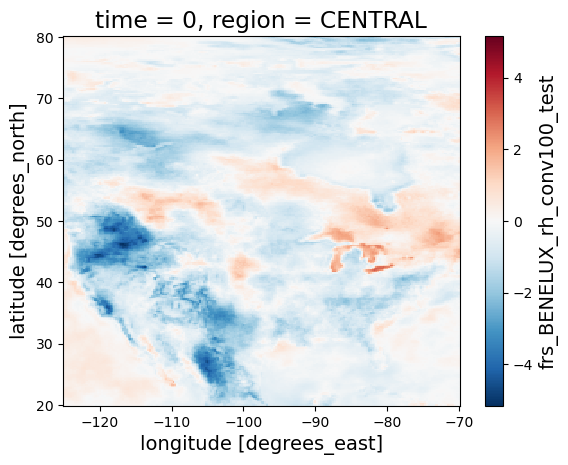

In [18]:
data.sel(region='CENTRAL',time=0).plot()

In [41]:

scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
#files = glob(scr_data+'static_composite_frs_*_DI_*test*')
vars = ['q800','rh800','rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_inf','WCB_mid','cape']
clabels = [r"$\Delta$ 800 hPa Specific Humidity [%]",r"$\Delta$ 800 hPa Relative Humidity [%]",r"$\Delta$ 900 hPa Relative Humidity [%]",r"$\Delta$ 2m Relative Humidity [%]",r"$\Delta$ Sea Surface Temperature [°C]",
           r"$\Delta$ 900 hPa Specific Humidity [g kg$^{-1}$]",r"$\Delta$ 500 hPa Geopotential Height [m]",
           r"$\Delta$ 2m Temperature [°C]",r"$\Delta$ Surface Soil Moisture [l m$^{-3}$]",r"Heatwave Occurrence [0-1]",
           r"$\Delta$ Convective Precipitation [mm]",r"Convective Proxy [0-1]",r"$\Delta$ Dry Intrusions [0-1]",
           r"$\Delta$ Warm Conveyor Belt Inflow [0-1]",r"$\Delta$ Warm Conveyor Belt Ascent [0-1]",
           r"$\Delta$ CAPE [J kg$^{-1}$]",]
latslices=[slice(37,55),
          slice(30,60)]
lonslices=[slice(-6,30),
           slice(-15,40)]
cmaps = ['BrBG','BrBG','BrBG','BrBG','RdBu_r','BrBG','RdBu_r','RdBu_r','BrBG','Reds','Blues','bone_r','RdBu_r','RdBu_r','RdBu_r','Reds']
scope = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']
lats = [slice(45,55),slice(45,55),slice(45,55),slice(45,55),slice(45,55),slice(45,55),slice(35,45),slice(35,45),slice(35,45),slice(35,45)]
ids = [3,10,7,6,8,5,4,2]
days = ['str_mlt','sgl','frs']#['frs','sgl','mlt','all']
vars = ['q800','rh800','rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_inf','WCB_mid','cape']

bounds = [np.arange(-1,1.1,0.2),
          np.arange(-8,8.1,1),
          np.arange(-8,8.1,1),
          np.arange(-4,4.1,1),
          np.arange(-1,1.1,0.2),
          np.arange(-1.5,1.51,0.3),
          np.arange(-50,51,10),
          np.arange(-3,3.1,0.5),
          np.arange(-20,20.1,4),
          np.arange(0,31,5),
          np.arange(0,2,0.4),
          np.arange(0,0.51,0.05),
          np.arange(-15,15.1,3),
          np.arange(-15,15.1,3),
          np.arange(-15,15.1,3),
          np.arange(0,1001,50),
]
for day in days:
    for n1 in range(len(vars))[3:4]:
        var = vars[n1]
        print(var)
        data=[]
        pval=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]

            file = glob(scr_data+'static_pval_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            pval.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            pval[n] = pval[n][list(pval[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        pval = xr.concat(pval,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        if var=='rh': data = data*100
        if var=='SWVL1': data = data*1000
        if var=='DI': data = data*100
        if var=='WCB_all': data = data*100
        if var=='WCB_inf': data = data*100
        if var=='WCB_mid': data = data*100
        if var=='hwp': data = data*100
        if var=='q900': data = data*1000
        if var=='q800': data = data*1000
        if var=='z500': data = data/9.81

        # p,axes = plt.subplots(2,4,figsize=(12, 6), layout='compressed')

        p = data.sel(lat=slice(40,55),lon=slice(-15,40)).mean(dim='lat').plot.contourf(x='lon',y='time',col='region',col_wrap=4,
                                    cmap=cmaps[n1],levels=bounds[n1],extend='both',yincrease=False, add_colorbar=False)
        
        n2=0
        for ax in p.axs.flat:
            lab = labels==ids[n2]
            lab = lab.where(lab != False, np.nan)
            lons = lab * labels.lon
            lonmin = np.nanmin(lons)
            lonmax = np.nanmax(lons)
            lats = lab * labels.lat
            latmin = np.nanmin(lats)
            latmax = np.nanmax(lats)
            if var=='sst':
                latmin-=5
                latmax+=5
            print(latmin,latmax,regs[n2])
            dsel = data.sel(lat=slice(latmin,latmax),lon=slice(-15,40),region=regs[n2])
            dsel.mean(dim='lat').plot.contourf(x='lon',y='time',col_wrap=4, ax=ax,
                    cmap=cmaps[n1],levels=bounds[n1],extend='both',yincrease=False, add_colorbar=False)
            psel = pval.sel(lat=slice(latmin,latmax),lon=slice(-15,40),region=regs[n2])
            pcor = psel.values.flatten()
            nan_mask = np.isnan(pcor)
            pp = pcor[~nan_mask]
            psel_fdr = fdrcorrection(pp)[1]
            pcor[~nan_mask] = psel_fdr
            psel_fdr = pcor.reshape(psel.shape)
            psel_mean = combine_pvalues(psel_fdr,axis=1,method='stouffer').pvalue
            p_values_hovmoller = xr.DataArray(
                psel_mean,
                coords={ "time": dsel.time, "lon": dsel.lon },  # Preserve time/lon coordinates
                dims=["time", "lon"],
            )
            hatch_plot = p_values_hovmoller.plot.contourf(ax=ax,
                colors='none',hatches=['','xxx',''],levels=[0,0.05,1],yincrease=False, add_colorbar=False)
            for collection in hatch_plot.collections:
                collection.set_edgecolor('darkgrey')
                collection.set_linewidth(0) 
            if n2==4: ax.text(27,-3.7,'W-M')
            else: ax.text(31,-3.7,regs[n2][:2])
            ax.axvline(lonmin,color='black')
            ax.axvline(lonmax,color='black')
            ax.axhline(0,color='black',linestyle='dashed')
            ax.set_xlabel('')
            ax.set_ylabel('')
            if n2>3: ax.set_xlabel('Longitude',fontsize=10)
            if n2==0 or n2==4: ax.set_ylabel('days',fontsize=10)
            ax.set_xticks(np.arange(-10,41,10))
            ax.set_yticks(np.arange(-5,6))
            # lab = labels==ids[n2]
            # lab.sel(lat=latslices[scope[n1]],lon=lonslices[scope[n1]]).plot.contour(linewidths=0.5,colors='grey',linestyles='solid',ax=ax)
            # ax.invert_yaxis()
            # ax.coastlines()
            ax.set_title('')
            #ax.set_title(regs[n2])
            n2+=1
        f=p.fig
        contour_set = p._mappables[0] 
        #f.title(titles[n1])
        cbar = f.colorbar(contour_set, ax=p.axs, orientation='vertical', shrink=0.8,ticks=bounds[n1][::2])
        cbar.set_label(clabels[n1],fontsize=10)
        f.tight_layout(rect=[0, 0, 0.825, 1]) 
        f.set_figheight(4)
        f.savefig(figs+var+'_'+day+'_hovm_regs.png',  dpi=300, format=None,bbox_inches='tight')
        plt.close(f)
        n1+=1



rh
43.5 54.5 BENELUX


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 53.75 CENTRAL


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.75 51.75 SLAV


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 52.25 EAST


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


39.75 47.5 W-MED


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


43.75 47.5 ALTA-ITALIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


38.0 45.75 ADRIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


37.25 45.5 HELLEN


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1346018222.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout(rect=[0, 0, 0.825, 1])


rh
43.5 54.5 BENELUX


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 53.75 CENTRAL


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.75 51.75 SLAV


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 52.25 EAST


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


39.75 47.5 W-MED


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


43.75 47.5 ALTA-ITALIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


38.0 45.75 ADRIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


37.25 45.5 HELLEN


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1346018222.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout(rect=[0, 0, 0.825, 1])


rh
43.5 54.5 BENELUX


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 53.75 CENTRAL


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.75 51.75 SLAV


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


44.5 52.25 EAST


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


39.75 47.5 W-MED


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


43.75 47.5 ALTA-ITALIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


38.0 45.75 ADRIA


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:


37.25 45.5 HELLEN


/tmp/ipykernel_3213216/1346018222.py:107: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in hatch_plot.collections:
/tmp/ipykernel_3213216/1346018222.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout(rect=[0, 0, 0.825, 1])


In [ ]:
projection = ccrs.PlateCarree()
files = glob(scr_data+'composite/static_composite_frs_*_DI_*test*')
vars = ['rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_all']
cmaps = ['BrBG','BrBG','seismic','BrBG','seismic','seismic','BrBG','Reds','Blues','bone_r','Greens','Oranges']
regs = ['BENELUX','CENTRAL','SLAV','EAST','W-MED','ALTA-ITALIA','ADRIA','HELLEN']

days = ['frs','sgl','mlt','all']
for day in days:
    n1=0
    for var in vars[:]:
        data=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'composite/static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(lat=slice(35,50)).mean(dim='lat').plot.contourf(x='lon',y='time',col='region',col_wrap=4,cmap=cmaps[n1],levels=15,yincrease=False)
                                    # transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()})
        for ax in p.axs.flat:
            ax.invert_yaxis()
            # ax.coastlines()
        f=p.fig
        f.set_figheight(6)
        f.savefig(figs+var+'_'+day+'_hovm_regs.png',  dpi=300, format=None,)
        n1+=1




In [ ]:
scr_data='/storage/homefs/mf23m219/clim/composite/'
projection = ccrs.PlateCarree()
files = glob(scr_data+'static_composite_frs_*_DI_*test*')
vars = ['rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_all']
cmaps = ['BrBG','BrBG','seismic','BrBG','seismic','seismic','BrBG','Reds','Blues','bone_r','Greens','Oranges']
regs = ['BENELUX','ALTA-ITALIA']
days = ['frs','sgl','mlt','all']
for day in days:
    n1=0
    for var in vars[:]:
        data=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(time=0).plot.contourf(x='lon',y='lat',col='region',col_wrap=2,cmap=cmaps[n1],levels=15,
                                    transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()})
        for ax in p.axs.flat:
            ax.coastlines()
        f=p.fig
        f.set_figheight(2)
        f.savefig(figs+var+'_'+day+'_t0_case.png',  dpi=300, format=None,)
        n1+=1


In [ ]:
projection = ccrs.PlateCarree()
files = glob(scr_data+'composite/static_composite_frs_*_DI_*test*')
vars = ['rh900','rh','sst','q900','z500','t2m','SWVL1','hwp','cp','conv_EU','DI','WCB_all']
cmaps = ['BrBG','BrBG','seismic','BrBG','seismic','seismic','BrBG','Reds','Blues','bone_r','Greens','Oranges']
regs = ['BENELUX','ALTA-ITALIA']
days = ['frs','sgl','mlt','all']
for day in days:
    n1=0
    for var in vars[:]:
        data=[]
        n=0
        for reg in regs:
            file = glob(scr_data+'composite/static_composite_'+day+'_'+reg+'_'+var+'_conv100_test.nc')[0]
            data.append(xr.open_dataset(file).expand_dims(dim="region").assign_coords(region=("region", [reg])))
            data[n] = data[n][list(data[n].data_vars)[0]]
            n+=1
        data = xr.concat(data,dim='region')
        if var=='cp': data = data*1000*24*(data>0)
        #fig,axes = plt.subplots(2,4,figsize=(12, 6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
        p = data.sel(lat=slice(35,50)).mean(dim='lat').plot.contourf(x='lon',y='time',col='region',col_wrap=2,cmap=cmaps[n1],levels=15,yincrease=False)
                                    # transform=ccrs.PlateCarree(), subplot_kws={'projection':ccrs.PlateCarree()})
        for ax in p.axs.flat:
            ax.invert_yaxis()
            # ax.coastlines()
        f=p.fig
        f.set_figheight(2)
        f.savefig(figs+var+'_'+day+'_hovm_case.png',  dpi=300, format=None,)
        n1+=1


In [ ]:
data.data_vars

In [ ]:
glob(scr_data+'static_composite_frs_'+reg+'_*_conv100_test.nc')

In [ ]:
hw_file = glob(scr_data+'composite*hwp_clim_*cp*.nc')[0]
z_file = glob(scr_data+'composite*z500_clim_*std*cp*.nc')[0]
conv_file = glob(scr_data+'composite*conv_EU_bin_*cp*.nc')[0] 
cp_file = glob(scr_data+'composite*cp_abs_*cp*.nc')[0] 
t2m_file = glob(scr_data+'composite*t2m_clim_*cp*.nc')[0]
sm_file = glob(scr_data+'composite*SWVL1_clim_*cp*.nc')[0]
wcb_file = glob(scr_data+'composite*rh_clim_*cp*.nc')[0]

heat = xr.open_dataarray(hw_file)
z500 = xr.open_dataarray(z_file) #/ 9.81
conv = xr.open_dataarray(conv_file)
cp = xr.open_dataarray(cp_file) * 1000 * 24
t2m = xr.open_dataarray(t2m_file)
sm = xr.open_dataarray(sm_file)
wcb = xr.open_dataarray(wcb_file) *100

In [ ]:
hw_file = glob(scr_data+'static_composite*hwp_clim_*.nc')[0]
z_file = glob(scr_data+'static_composite*z500_clim_*std*.nc')[0]
conv_file = glob(scr_data+'static_composite*conv_EU_bin_*.nc')[0] 
cp_file = glob(scr_data+'static_composite*cp_abs_*.nc')[0] 
t2m_file = glob(scr_data+'static_composite*t2m_clim_*.nc')[0]
sm_file = glob(scr_data+'static_composite*SWVL1_clim_*.nc')[0]
wcb_file = glob(scr_data+'static_composite*rh_clim_*.nc')[0]

heat = xr.open_dataarray(hw_file)
z500 = xr.open_dataarray(z_file) #/ 9.81
conv = xr.open_dataarray(conv_file)
cp = xr.open_dataarray(cp_file) * 1000 * 24
t2m = xr.open_dataarray(t2m_file)
sm = xr.open_dataarray(sm_file)
wcb = xr.open_dataarray(wcb_file) *100

In [ ]:
fig, axes = plt.subplots(3,7,figsize=(25,10), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')

# conv = conv.where(conv > 0 )
# heat = heat.where(heat > 0 )

conv.sel(time=-1).plot.contourf(ax=axes[0,0],transform=ccrs.PlateCarree(),
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=-1).plot.contourf(ax=axes[0,1],transform=ccrs.PlateCarree(),
                cmap='Reds',levels=np.arange(0,0.21,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=-1).plot.contourf(ax=axes[0,2],transform=ccrs.PlateCarree(),
                cmap='PuOr_r',levels=np.arange(-0.5,0.51,0.1), cbar_kwargs={'label': '$\\Delta$ z500 [std]'})
t2m.sel(time=-1).plot.contourf(ax=axes[0,3],transform=ccrs.PlateCarree(),
                cmap='RdBu_r',levels=np.arange(-1.5,1.51,0.25), cbar_kwargs={'label': '$\\Delta$ t2m [°C]'})
sm.sel(time=-1).plot.contourf(ax=axes[0,4],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-0.02,0.021,0.004), cbar_kwargs={'label': '$\\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=-1).plot.contourf(ax=axes[0,5],transform=ccrs.PlateCarree(),
                cmap='Blues',levels=np.arange(0,2.1,0.2), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=-1).plot.contourf(ax=axes[0,6],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\\Delta$ RH [%]'})
conv.sel(time=0).plot.contourf(ax=axes[1,0],transform=ccrs.PlateCarree(),
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=0).plot.contourf(ax=axes[1,1],transform=ccrs.PlateCarree(),
                cmap='Reds',levels=np.arange(0,0.21,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=0).plot.contourf(ax=axes[1,2],transform=ccrs.PlateCarree(),
                cmap='PuOr_r',levels=np.arange(-0.5,0.51,0.1), cbar_kwargs={'label': '$\\Delta$ z500 [std]'})
t2m.sel(time=0).plot.contourf(ax=axes[1,3],transform=ccrs.PlateCarree(),
                cmap='RdBu_r',levels=np.arange(-1.5,1.51,0.25), cbar_kwargs={'label': '$\\Delta$ t2m [°C]'})
sm.sel(time=0).plot.contourf(ax=axes[1,4],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-0.02,0.021,0.004), cbar_kwargs={'label': '$\\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=0).plot.contourf(ax=axes[1,5],transform=ccrs.PlateCarree(),
                cmap='Blues',levels=np.arange(0,2.1,0.2), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=0).plot.contourf(ax=axes[1,6],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\\Delta$ RH [%]'})
conv.sel(time=1).plot.contourf(ax=axes[2,0],transform=ccrs.PlateCarree(),
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=1).plot.contourf(ax=axes[2,1],transform=ccrs.PlateCarree(),
                cmap='Reds',levels=np.arange(0,0.21,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=1).plot.contourf(ax=axes[2,2],transform=ccrs.PlateCarree(),
                cmap='PuOr_r',levels=np.arange(-0.5,0.51,0.1), cbar_kwargs={'label': '$\\Delta$ z500 [std]'})
t2m.sel(time=1).plot.contourf(ax=axes[2,3],transform=ccrs.PlateCarree(),
                cmap='RdBu_r',levels=np.arange(-1.5,1.51,0.25), cbar_kwargs={'label': '$\\Delta$ t2m [°C]'})
sm.sel(time=1).plot.contourf(ax=axes[2,4],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-0.02,0.021,0.004), cbar_kwargs={'label': '$\\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=1).plot.contourf(ax=axes[2,5],transform=ccrs.PlateCarree(),
                cmap='Blues',levels=np.arange(0,2.1,0.2), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=1).plot.contourf(ax=axes[2,6],transform=ccrs.PlateCarree(),
                cmap='BrBG',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\\Delta$ RH [%]'})
for ax in axes.flatten():
    ax.gridlines(draw_labels=True)

fig.savefig(figs+'dyn_conv_100CW_wcball.png',dpi=300)

In [ ]:
scr_data='/storage/homefs/mf23m219/clim/cookies/'
hw_file = glob(scr_data+'cookie*hw_clim_*.nc')[0]
z_file = glob(scr_data+'cookie*z500_clim_*.nc')[0]
conv_file = glob(scr_data+'cookie*conv_EU_bin_*.nc')[0]
cp_file = glob(scr_data+'cookie*cp_abs_*.nc')[0]
t2m_file = glob(scr_data+'cookie*t2m_clim_*.nc')[0]
sm_file = glob(scr_data+'cookie*SWVL1_clim_*.nc')[0]
wcb_file = glob(scr_data+'cookie*rh_clim_*.nc')[0]

heat = xr.open_dataarray(hw_file)
lims = np.round(len(heat.events)/2)
#heat = heat.sel(events=slice(lims,-1)).mean(dim='events')
z500 = xr.open_dataarray(z_file).sel(events=slice(lims,-1)).mean(dim='events',skipna=True) / 9.81
conv = xr.open_dataarray(conv_file)#.sel(events=slice(lims,-1)).mean(dim='events',skipna=True)
cp = xr.open_dataarray(cp_file).sel(events=slice(lims,-1)).mean(dim='events',skipna=True) * 1000 * 24
t2m = xr.open_dataarray(t2m_file).sel(events=slice(lims,-1)).mean(dim='events',skipna=True)
sm = xr.open_dataarray(sm_file).sel(events=slice(lims,-1)).mean(dim='events',skipna=True)
wcb = xr.open_dataarray(wcb_file).sel(events=slice(lims,-1)).mean(dim='events',skipna=True)


In [ ]:
bin = conv>0
size = bin.sel(time=0).sum(dim=['lat','lon'])
sel = size>100
heat = heat.sel(events=heat.events[sel]).mean(dim='events')

In [ ]:
np.nanmin(size)

In [ ]:
len(conv.sum(dim=['lat','lon'],skipna=True))

In [ ]:
fig, axes = plt.subplots(3,7,figsize=(18,6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')

# conv = conv.where(conv > 0 )
# heat = heat.where(heat > 0 )

conv.sel(time=-1).plot.contourf(ax=axes[0,0],
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=-1).plot.contourf(ax=axes[0,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=-1).plot.contourf(ax=axes[0,2],
                cmap='PuOr_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=-1).plot.contourf(ax=axes[0,3],
                cmap='RdBu_r',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=-1).plot.contourf(ax=axes[0,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=-1).plot.contourf(ax=axes[0,5],
                cmap='Blues',levels=np.arange(0,4.1,0.4), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=-1).plot.contourf(ax=axes[0,6],
                cmap='Greens',levels=np.arange(0,0.41,0.04), cbar_kwargs={'label': 'WCB [0/1]'})
conv.sel(time=0).plot.contourf(ax=axes[1,0],
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=0).plot.contourf(ax=axes[1,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=0).plot.contourf(ax=axes[1,2],
                cmap='PuOr_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=0).plot.contourf(ax=axes[1,3],
                cmap='RdBu_r',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=0).plot.contourf(ax=axes[1,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=0).plot.contourf(ax=axes[1,5],
                cmap='Blues',levels=np.arange(0,4.1,0.4), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=0).plot.contourf(ax=axes[1,6],
                cmap='Greens',levels=np.arange(0,0.41,0.04), cbar_kwargs={'label': 'WCB [0/1]'})
conv.sel(time=1).plot.contourf(ax=axes[2,0],
                cmap='cividis',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=1).plot.contourf(ax=axes[2,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=1).plot.contourf(ax=axes[2,2],
                cmap='PuOr_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=1).plot.contourf(ax=axes[2,3],
                cmap='RdBu_r',levels=np.arange(-4,4.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=1).plot.contourf(ax=axes[2,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})
cp.sel(time=1).plot.contourf(ax=axes[2,5],
                cmap='Blues',levels=np.arange(0,4.1,0.4), cbar_kwargs={'label': 'Conv precip [mm]'})
wcb.sel(time=1).plot.contourf(ax=axes[2,6],
                cmap='Greens',levels=np.arange(0,0.41,0.04), cbar_kwargs={'label': 'WCB [0/1]'})

fig.savefig(figs+'dyn_conv_100CW_wcball.png',dpi=300)

In [ ]:
hw_file = glob(scr_data+'hw_*composite*_100.nc')[0]
z_file = glob(scr_data+'z500_anom*composite*_100.nc')[0]
conv_file = glob(scr_data+'conv_abs*composite*_100.nc')[0]
t2m_file = glob(scr_data+'t2m_anom*composite*_100.nc')[0]
sm_file = glob(scr_data+'SWVL1_anom*composite*_100.nc')[0]

heat = xr.open_dataarray(hw_file)
z500 = xr.open_dataarray(z_file) / 9.81
conv = xr.open_dataarray(conv_file)
t2m = xr.open_dataarray(t2m_file)
sm = xr.open_dataarray(sm_file)

In [ ]:
fig, axes = plt.subplots(3,5,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')

conv = conv.where(conv > 0 )
heat = heat.where(heat > 0 )

conv.sel(time=-1).plot.contourf(ax=axes[0,0],
                cmap='Reds',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=-1).plot.contourf(ax=axes[0,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=-1).plot.contourf(ax=axes[0,2],
                cmap='RdBu_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=-1).plot.contourf(ax=axes[0,3],
                cmap='RdBu_r',levels=np.arange(-3,3.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=-1).plot.contourf(ax=axes[0,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})
conv.sel(time=0).plot.contourf(ax=axes[1,0],
                cmap='Reds',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=0).plot.contourf(ax=axes[1,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=0).plot.contourf(ax=axes[1,2],
                cmap='RdBu_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=0).plot.contourf(ax=axes[1,3],
                cmap='RdBu_r',levels=np.arange(-3,3.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=0).plot.contourf(ax=axes[1,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})
conv.sel(time=1).plot.contourf(ax=axes[2,0],
                cmap='Reds',levels=np.arange(0,0.51,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=1).plot.contourf(ax=axes[2,1],
                cmap='Reds',levels=np.arange(0,0.41,0.05), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=1).plot.contourf(ax=axes[2,2],
                cmap='RdBu_r',levels=np.arange(-60,61,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=1).plot.contourf(ax=axes[2,3],
                cmap='RdBu_r',levels=np.arange(-3,3.1,0.5), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
sm.sel(time=1).plot.contourf(ax=axes[2,4],
                cmap='BrBG',levels=np.arange(-0.03,0.031,0.005), cbar_kwargs={'label': '$\Delta$ SWVL [m$^3$ m$^{-3}$]'})

In [ ]:
hw_file = glob(scr_data+'hw_*composite*_composite.nc')[0]
z_file = glob(scr_data+'z500_anom*composite*_composite.nc')[0]
conv_file = glob(scr_data+'conv_abs*composite*_composite.nc')[0]
t2m_file = glob(scr_data+'t2m_anom*composite*_composite.nc')[0]
sm_file = glob(scr_data+'SWVL1_anom*composite*_composite.nc')[0]

heat = xr.open_dataarray(hw_file)
z500 = xr.open_dataarray(z_file) / 9.81
conv = xr.open_dataarray(conv_file)
t2m = xr.open_dataarray(t2m_file)
sm = xr.open_dataarray(sm_file)

In [ ]:
fig, axes = plt.subplots(3,4,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')

conv = conv.where(conv > 0 )
heat = heat.where(heat > 0 )

conv.sel(time=-1).plot.contourf(ax=axes[0,0],
                cmap='Reds',levels=np.arange(0,0.5,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=-1).plot.contourf(ax=axes[0,1],
                cmap='Reds',levels=np.arange(0,0.3,0.03), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=-1).plot.contourf(ax=axes[0,2],
                cmap='RdBu_r',levels=np.arange(-80,80,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=-1).plot.contourf(ax=axes[0,3],
                cmap='RdBu_r',levels=np.arange(-2,2,0.2), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
conv.sel(time=0).plot.contourf(ax=axes[1,0],
                cmap='Reds',levels=np.arange(0,0.5,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=0).plot.contourf(ax=axes[1,1],
                cmap='Reds',levels=np.arange(0,0.3,0.03), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=0).plot.contourf(ax=axes[1,2],
                cmap='RdBu_r',levels=np.arange(-80,80,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=0).plot.contourf(ax=axes[1,3],
                cmap='RdBu_r',levels=np.arange(-2,2,0.2), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})
conv.sel(time=1).plot.contourf(ax=axes[2,0],
                cmap='Reds',levels=np.arange(0,0.5,0.05), cbar_kwargs={'label': 'Convection [0/1]'})
heat.sel(time=1).plot.contourf(ax=axes[2,1],
                cmap='Reds',levels=np.arange(0,0.3,0.03), cbar_kwargs={'label': 'Heatwave [0/1]'})
z500.sel(time=1).plot.contourf(ax=axes[2,2],
                cmap='RdBu_r',levels=np.arange(-80,80,10), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
t2m.sel(time=1).plot.contourf(ax=axes[2,3],
                cmap='RdBu_r',levels=np.arange(-2,2,0.2), cbar_kwargs={'label': '$\Delta$ t2m [°C]'})

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree()}, layout='compressed')
latslice=slice(30,60);lonslice=slice(-30,30)
conv = conv.where(conv['conv'] > 0 )
heat = heat.where(heat['heat'] > 0 )

conv.conv.sel(lag=0,index_val=1,lat=latslice,lon=lonslice).plot.contourf(ax=axes[0,0],
                cmap='Reds',levels=np.arange(-0.99,1.5,1), add_colorbar=False,)
heat.heat.sel(lag=1,index_val=1,lat=latslice,lon=lonslice).plot.contourf(ax=axes[0,1],
                cmap='Reds',levels=np.arange(-0.99,1.5,1), add_colorbar=False)
z500.z500.sel(lag=0,index_val=1,lat=latslice,lon=lonslice).plot.contourf(ax=axes[1,0],
                cmap='RdBu_r',levels=np.arange(-200,201,20), cbar_kwargs={'label': '$\Delta$ z500 [m]'})
z500.z500.sel(lag=1,index_val=1,lat=latslice,lon=lonslice).plot.contourf(ax=axes[1,1],
                cmap='RdBu_r',levels=np.arange(-200,201,20), cbar_kwargs={'label': '$\Delta$ z500 [m]'})

# conv_s.conv.sel(lag=0,index_val=1,lat=latslice,lon=lonslice,region='CENTRAL').plot.contourf(ax=axes[0,0],
#                 colors='none',hatches=['xx',' ',' '],levels=[-0.5,0.5,1], add_colorbar=False)
# heat_s.heat.sel(lag=1,index_val=1,lat=latslice,lon=lonslice,region='CENTRAL').plot.contourf(ax=axes[0,1],
#                 colors='none',hatches=['xx',' ',' '],levels=[-0.5,0.5,1], add_colorbar=False)
# z500_s.z500.sel(lag=0,index_val=1,lat=latslice,lon=lonslice,region='CENTRAL').plot.contourf(ax=axes[1,0],
#                 colors='none',hatches=['xx',' ',' '],levels=[-0.5,0.5,1], add_colorbar=False)
# z500_s.z500.sel(lag=1,index_val=1,lat=latslice,lon=lonslice,region='CENTRAL').plot.contourf(ax=axes[1,1],
#                 colors='none',hatches=['xx',' ',' '],levels=[-0.5,0.5,1], add_colorbar=False)

titles=['a) convective proxy, lag 0 days','b) heatwave, lag 1 day','c) z500 anomaly, lag 0 days','d) z500 anomaly, lag 1 day']
# labels=['frequency of convective environment [0-1]','frequency of heatwave [0-1]','$\Delta$ z500 [m]','$\Delta$ z500 [m]']
a=0
for ax in axes.flat:
        ax.coastlines()
        ax.set_title(' ')
        ax.set_title(titles[a])
        # ax.colorbar.set_label(labels[a])
        a+=1
#plt.tight_layout()
plt.savefig(figs+'case_CENTRAL.png',  dpi=300, format=None,)